# compare 2 methods of calling - concat vs individual

In [20]:
import sys,os,shutil,subprocess
import random
import glob, time, platform
import tempfile
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import seaborn as sns
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from gzip import open as gzopen
from tqdm.notebook import tqdm
sys.path.append('snipgenie')
from snipgenie import tools, aligners, app, tools, trees

In [ ]:
reload(app)
ref = app.sarscov2_genome
args = {'threads':12, 'outdir': 'simdata/sim_results', 'labelsep':'.',
        'input':'simdata/sim_fastq/',        
        'reference': ref,
        'overwrite':False,
        'filters':'', 
        'custom_filters': False, 'get_stats':False}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [207]:
samples = pd.read_csv('simdata/sim_results/samples.csv')

In [25]:
def compare_results(c1, c2, sample=None):
    """
    Compare two runs of snipgenie.
    """

    x = c1[~c1.pos.isin(c2.pos)]
    y = c2[~c2.pos.isin(c1.pos)]
    print ('%s/%s sites not in second:' %(len(x),len(c1)))
    print (x)
    print ('-------------------------')
    print ('%s/%s sites not in first:' %(len(y),len(c2)))
    print (y)
    return x,y

In [106]:
import multiprocessing as mp

def worker(args):
    mpileup(args[0], args[1])
        
def mpileup_multiprocess(bam_files, ref, outpath, threads=4, callback=None):
    """Run mpileup in parallel over multiple files and make separate bcfs.
    Assumes alignment to a bacterial reference with a single chromosome."""

    bcftoolscmd = tools.get_cmd('bcftools')
    #size = len(bam_files) 
    #pool = mp.Pool(threads)
    outfiles = []
    st = time.time()
    bcfpath = os.path.join(outpath,'bcf')
    if not os.path.exists(bcfpath):
        os.mkdir(bcfpath)
    for bam_file in bam_files:
        name = os.path.splitext(os.path.basename(bam_file))[0]
        out = '{o}/{f}.bcf'.format(o=bcfpath,f=name) 
        outfiles.append(out)
   
    data = list(zip(bam_files,outfiles))
    #print (data)
   
    p = mp.Pool(threads)
    p.map_async(worker, data)
    p.close()
    p.join()
    
    t=time.time()-st
    print ('took %s seconds' %str(round(t,3)))
    rawbcf = os.path.join(outpath,'raw.bcf')
    bcf_files = ' '.join(outfiles)
    cmd = '{bc} merge --threads {t} -o {r} {b}'.format(b=bcf_files,r=rawbcf, bc=bcftoolscmd,t=threads)
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    return rawbcf

def mpileup_files(bam_files, ref, outpath, threads=4):
    """mpileup bam files"""
    
    bcftoolscmd = tools.get_cmd('bcftools')
    outfiles = []
    st = time.time()
    bcfpath = os.path.join(outpath,'bcf')
    if not os.path.exists(bcfpath):
        os.mkdir(bcfpath)
    for bam_file in bam_files:
        name = os.path.splitext(os.path.basename(bam_file))[0]
        out = '{o}/{f}.bcf'.format(o=bcfpath,f=name) 
        outfiles.append(out)        
   
    data = list(zip(bam_files,outfiles)) 
    #print (data)
    for f,out in data:
        mpileup(f, out, ref, threads=threads)
        
    t=time.time()-st
    print ('took %s seconds' %str(round(t,3)))
    rawbcf = os.path.join(outpath,'raw.bcf')
    bcf_files = ' '.join(outfiles)
    #print (bcf_files)
    cmd = '{bc} merge --threads {t} -0 -o {o} {b}'.format(b=bcf_files,o=rawbcf, bc=bcftoolscmd,t=threads)
    print (cmd)
    #subprocess.check_output(cmd, shell=True)
    #cmd = '{bc} norm -f {r} -O b -o {o} tmp.bcf'.format(o=rawbcf, bc=bcftoolscmd, r=ref) 
    subprocess.check_output(cmd, shell=True)    
    return rawbcf

def mpileup(bam_file, out, ref, threads=4, overwrite=False):
    """Run bcftools for single file."""

    bcftoolscmd = tools.get_cmd('bcftools')
    if overwrite==False and os.path.exists(out):
        return
    cmd = '{bc} mpileup -a {a} -O b --max-depth 500 --min-MQ 60 -f {r} -o {o} {b}'\
            .format(r=ref, b=bam_file, o=out, bc=bcftoolscmd, a=app.annotatestr, t=threads)
    subprocess.check_output(cmd, shell=True)  
    print (cmd)
    cmd = 'bcftools index {o}'.format(o=out)
    subprocess.check_output(cmd, shell=True)
    return
   

In [2]:
annotatestr = '"AD,ADF,ADR,DP,SP,INFO/AD,INFO/ADF,INFO/ADR"'

def mpileup_parallel(bam_file, ref, rawbcf, threads=4, callback=None, tempdir=None):
    """Run mpileup in over multiple regions with GNU parallel on linux or rush on Windows
      Separate bcf files are then joined together.
      Assumes alignment to a bacterial reference with a single chromosome.
    """

    if tempdir == None:
        tempdir = tempfile.tempdir
    #bam_files = ' '.join(bam_files)
    #rawbcf = os.path.join(outpath,'raw.bcf')
    chr = tools.get_chrom(ref)
    length = tools.get_fasta_length(ref)
    x = np.linspace(1,length,threads+1,dtype=int)
    print (x)

    #split genome into blocks
    blocks=[]
    for i in range(len(x)):
        if i < len(x)-1:
            blocks.append((x[i],x[i+1]-1))

    #get temp outfile names
    outfiles = []
    regions = []
    for start,end in blocks:
        region = '"{c}":{s}-{e}'.format(c=chr,s=start,e=end)
        regions.append(region)
        out = os.path.join(tempdir,'{s}-{e}.bcf'.format(s=start,e=end))
        outfiles.append(out)

    regstr = ' '.join(regions)
    #print (regstr)
    filesstr = ' '.join(outfiles)
    bcftoolscmd = tools.get_cmd('bcftools')

    if platform.system() == 'Windows':
        rushcmd = tools.get_cmd('rush')
        cmd = 'echo {reg} | {rc} -D " " "{bc} mpileup -r {{}} -f {r} -a {a} --max-depth 500 --min-MQ 60 {b} -o {p}/{{@[^:]*$}}.bcf"'\
                .format(rc=rushcmd,bc=bcftoolscmd,reg=regstr,r=ref,b=bam_file,a=annotatestr,p=tempdir)
    else:
        cmd = 'parallel bcftools mpileup -r {{1}} -a {a} -O b --max-depth 500 --min-MQ 60 -o {{2}} -f {r} {b} ::: {reg} :::+ {o}'\
                .format(r=ref, reg=regstr, b=bam_file, o=filesstr, a=annotatestr)
    #print (cmd)
    #if callback != None:
    #    callback(cmd)
    subprocess.check_output(cmd, shell=True, stderr=subprocess.PIPE)
    #concat the separate files
    cmd = '{bc} concat {i} --threads {t} -O b -o {o}'.format(bc=bcftoolscmd,i=' '.join(outfiles),o=rawbcf,t=threads)
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    #remove temp files
    for f in outfiles:
        os.remove(f)
    return rawbcf

In [3]:
reload(tools)

path = 'simdata/sim_results2/variant_calling/S1'
bam_file = 'simdata/sim_results/mapped/S1.bam'
#app.run_file(bam_file, app.sarscov2_genome, path, overwrite=True)


In [ ]:
def worker(args):
    run_file(args[0], args[1], args[2], args[3])  
        
def variant_calling_multiprocess(samples, ref, outpath, filters=None, custom_filters=False, mask=None,
                        overwrite=False, threads=4):
  
    bcftoolscmd = tools.get_cmd('bcftools')
    vcfoutpath = os.path.join(outpath, 'variant_calling')
    os.makedirs(vcfoutdir, exist_ok=True)    
    if samples is not None:
        #write out new samples.txt file for reheader step
        app.write_samples(samples[['sample']], outpath)
        sample_file = os.path.join(outpath,'samples.txt') 
        
    outpaths = []
    #outfiles = []
    for i,r in samples.iterrows():    
        name = r['sample']
        path = os.path.join(vcfoutpath, name)
        #snpfile = run_file(r.bam_file, ref, path, filters=filters, mask=mask)
        
        #snpfile = os.path.join(vcfoutpath, name, 'snps.bcf')
        outfiles.append(snpfile)
    
    data = list(zip(bam_files,outpaths,mask))
    print (data)
   
    #p = mp.Pool(threads)
    #p.map_async(worker, data)
    #p.close()
    #p.join()

    

outdir='simdata/sim_results_parallel/'
variant_calling_multiprocess(samples, app.sarscov2_genome, outdir, filters=None)

In [4]:
def write_filelist(files, filename):
    """Write out sample names only using dataframe from get_samples"""

    df = pd.DataFrame(files)    
    df.to_csv(filename, index=False, header=False)
    return 
    
def new_variant_calling(samples, ref, outpath, filters=None, custom_filters=False, mask=None,
                        overwrite=False, threads=4):
    """
    Run variant calling for multiple samples
    """
    
    bcftoolscmd = tools.get_cmd('bcftools')
    vcfoutpath = os.path.join(outpath, 'variant_calling')
    os.makedirs(vcfoutpath, exist_ok=True)
    if samples is not None:
        #write out new samples.txt file for reheader step
        app.write_samples(samples[['sample']], outpath)
        sample_file = os.path.join(outpath,'samples.txt')
        
    outfiles = []    
    for i, r in tqdm(samples.iterrows(), total=len(samples)):
    #for i,r in samples.iterrows():    
        name = r['sample']
        #print (name)
        path = os.path.join(vcfoutpath, name)
        snpfile = run_file(r.bam_file, ref, path, filters=filters, mask=mask, threads=threads)
        outfiles.append(snpfile)

    #write file list
    bcffilelist = os.path.join(outpath, 'bcffiles.txt')
    write_filelist(outfiles, bcffilelist)
    merged = os.path.join(outpath, 'merged.vcf.gz')
    bcf_files = ' '.join(outfiles)
    #print (outfiles)
    cmd = '{bc} merge --threads {t} -0 -O z -o {o} --file-list {f}'.format(f=bcffilelist,o=merged, bc=bcftoolscmd,t=threads)
    print (cmd)
    subprocess.check_output(cmd, shell=True)  
    app.relabel_vcfheader(merged, sample_file)
    #custom filters
    if custom_filters == True:
        app.site_proximity_filter(merged, outdir=outpath, overwrite=True)
    return

outdir='simdata/sim_results2/'
#new_variant_calling(samples, app.sarscov2_genome, outdir, filters=None)
#app.run_vcf('simdata/sim_results2/merged.vcf.gz', outdir, threads=8)

## SNIPPY test

In [ ]:
outdir='simdata/snippy_results'
ref=app.sarscov2_genome
for i, r in samples.iterrows():    
    out = os.path.join(outdir, r['sample'])
    cmd = '/local/snippy/bin/snippy --cpus 8 --outdir {o} --ref {r} --R1 {f1} --R2 {f2}'.format(
            o=out,r=ref,f1=r.filename1,f2=r.filename2)
    print (cmd)
    subprocess.check_output(cmd, shell=True)

In [ ]:
cmd = "/local/snippy/bin/snippy-core --ref 'simdata/snippy_results/S1/ref.fa' S1 S10 S11 S2 S3 S4 S5 S6 S7 S8 S9"
subprocess.check_output(cmd, shell=True)

In [27]:
c1=pd.read_csv('simdata/sim_results/core.txt',sep=' ')
c2=pd.read_csv('simdata/sim_results2/core.txt',sep=' ')
c3=pd.read_csv('simdata/snippy_results/core.tab',sep='\t')
c3=c3.rename(columns={'POS':'pos'})
x,y=compare_results(c1,c2)


4/176 sites not in second:
       pos ref S1 S10 S11 S2 S3 S4 S5 S6 S7 S8 S9
25    3584   G  G   G   G  G  G  A  G  G  G  G  G
30    4588   A  A   A   G  A  A  A  A  A  A  A  A
31    4626   C  C   C   T  C  C  C  C  C  C  C  C
166  28546   C  C   C   C  C  C  C  C  C  C  C  T
-------------------------
0/172 sites not in first:
Empty DataFrame
Columns: [pos, ref, S1, S10, S11, S2, S3, S4, S5, S6, S7, S8, S9]
Index: []


In [ ]:
d1 = pd.read_csv('simdata/sim_results/snpdist.csv',index_col=0)
d2 = pd.read_csv('simdata/sim_results2/snpdist.csv',index_col=0)
print (d1)
print (d2)

## test with wicklow data

In [206]:
wsamples = pd.read_csv('/storage/btbgenie/wicklow_results/samples.csv')
bam_files = list(samples.bam_file.unique())
ref = app.mbovis_genome

In [ ]:
v1 = tools.vcf_to_dataframe(os.path.join('wicklow_results','snps.vcf.gz'))
v1
print (tools.bcftools_query('wicklow_results/raw.bcf',[205557]))
print (tools.bcftools_query('wicklow_temp/raw.bcf',[205557]))

In [ ]:
compare_results('/storage/btbgenie/wicklow_results','wicklow_temp')
#compare_results('wicklow_temp','/storage/btbgenie/wicklow_results')

In [ ]:
v1 = vcf_to_dataframe('result.vcf')
print (v1.var_type.value_counts())

In [ ]:
v2 = vcf_to_dataframe('mapped/raw.bcf')
print (v2.var_type.value_counts())

# run Ireland samples with new method

In [7]:
#app.clean_folders(iresamples, '/storage/btbgenie/all_ireland_results_new/variant_calling/')

TB22-005458
TB22-005451
TB22-005609


In [3]:
! ulimit -Sn

65000


In [ ]:
reload(app)
outdir='/storage/btbgenie/all_ireland_results_new'
iresamples = pd.read_csv('/storage/btbgenie/all_ireland_results_new/samples.csv')
variant_calling(iresamples, app.mbovis_genome, outdir, proximity=True, threads=12)
run_vcf(f'{outdir}/merged.vcf.gz', outdir, threads=12)

In [24]:
#treefile = trees.run_RAXML(f'{outdir}/core.fa', outpath=outdir, threads=12)
out = os.path.join(outdir,'tree.newick')
trees.run_fasttree(f'{outdir}/core.fa', out)

In [55]:
from multiprocessing import Pool

def compute_snp_count(args):
    i, j, seq1, seq2 = args
    return i, j, np.sum(np.fromiter((c1 != c2 for c1, c2 in zip(seq1, seq2)), dtype=int))

def snp_dist_matrix(aln, threads=4):
    """
    Compute the number of Single Nucleotide Polymorphisms (SNPs)
    between sequences in a Biopython alignment.
    Args:
        aln:
            Biopython multiple sequence alignment object.
    Returns:
        A matrix as pandas dataframe.
    """
    
    names = [s.id for s in aln]
    num_sequences = len(aln)
    matrix = np.zeros((num_sequences, num_sequences), dtype=int)
    sequences = [str(s.seq) for s in aln]

    args_list = []
    for i in range(num_sequences):
        seq1 = sequences[i]
        for j in range(i + 1, num_sequences):
            seq2 = sequences[j]
            args_list.append((i, j, seq1, seq2))

    with Pool(processes=threads) as pool:
        results = pool.map(compute_snp_count, args_list)

    for i, j, snp_count in results:
        matrix[i, j] = snp_count
        matrix[j, i] = snp_count

    m = pd.DataFrame(matrix, index=names, columns=names)
    return m
    

In [18]:
def snp_dist_matrix_old(aln):
    """
    Compute the number of Single Nucleotide Polymorphisms (SNPs)
    between sequences in a Biopython alignment.
    Args:
        aln:
            Biopython multiple sequence alignment object.
    returns:
        a matrix as pandas dataframe
    """

    names=[s.id for s in aln]
    num_sequences = len(aln)
    matrix = np.zeros((num_sequences, num_sequences))

    for i in range(num_sequences):
        seq1 = str(aln[i].seq)
        for j in range(i + 1, num_sequences):
            seq2 = str(aln[j].seq)
            # Calculate the number of SNPs
            snp_count = sum(c1 != c2 for c1, c2 in zip(seq1, seq2))
            matrix[i, j] = snp_count
            matrix[j, i] = snp_count

    m = pd.DataFrame(matrix,index=names,columns=names).astype(int)
    return m

In [72]:
#aln = AlignIO.read('simdata/sim_results/core.fa',format='fasta')
#aln = AlignIO.read('/storage/btbgenie/all_ireland_results/old_results/core.fa',format='fasta')
aln = AlignIO.read('/storage/btbgenie/all_ireland_results_new/core.fa',format='fasta')
st= time.time()
dm=snp_dist_matrix(aln, 12)
print (time.time()-st)

3.123283386230469e-05


In [ ]:
#test new snp dist calc
res=[]
for l in range(10,3500,1000):
    #print (l)
    #st= time.time()
    #dm=snp_dist_matrix_old(aln[:l])
    #t1 = time.time()-st    
    st= time.time()
    dm=snp_dist_matrix(aln[:l], 12)
    t2 = time.time()-st    
    SeqIO.write(aln[:l],'temp.fa','fasta')
    cmd = 'snp-dists -j 12 temp.fa'
    st= time.time()
    tmp=subprocess.check_output(cmd,shell=True)
    t3 = time.time()-st
    res.append([l,t2,t3]) 

res=pd.DataFrame(res,columns=['size','python-threaded','snp-dists'])

<Axes: xlabel='size'>

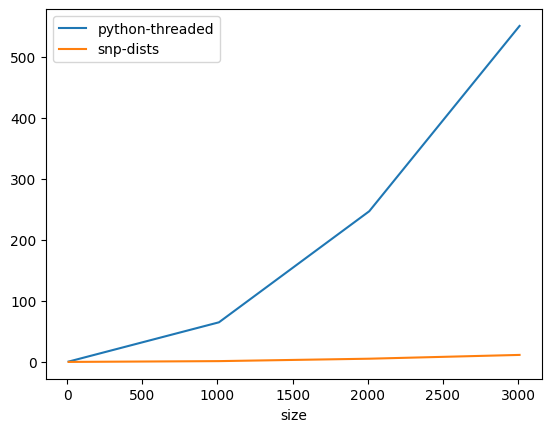

In [74]:
res.plot(x='size')#,kind='scatter')